<a href="https://colab.research.google.com/github/xy2119/GNN_with_Causal_Knowledge/blob/main/notebooks/0_ate_weighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook learns causal relationships between the target and each feature
Average Treatment Effect (ATE) of each feature is leanred, which is used as causal weighting

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import math
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int64Index
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from scipy import stats
from gensim.models import Word2Vec
import random
random.seed(2022)
np.random.seed(2022)

In [ ]:
multi_data=pd.read_csv("criteo-uplift-v2.1.csv")
multi_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
multi_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
original=multi_data.copy()
data=multi_data[[c for c in multi_data.columns[:-4]]+["visit","treatment"]]
data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,visit,treatment
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,0,1
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,1
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

numeric_disc=[]
numeric_cont=[]

for i in data.columns :
    if len(data[i].value_counts())<=3:
            numeric_disc.append(i)
            data[i]=data[i].fillna(data[i].mode()[0])
            print("discrete",i)
            continue
    if i not in (numeric_cont+numeric_disc+["conversion"]):      
        numeric_cont.append(i)
        scaler = MinMaxScaler()
        scaler=scaler.fit(np.array(data[i]).reshape(-1, 1))
        data[i]= data[i].fillna(data[i].mean())
        data[i] = scaler.transform(np.array(data[i]).reshape(-1, 1))
        print('continueous',i)

continueous f0
continueous f1
continueous f2
continueous f3
continueous f4
continueous f5
continueous f6
continueous f7
continueous f8
continueous f9
continueous f10
continueous f11
discrete visit
discrete treatment


In [ ]:
len(numeric_disc),len(numeric_cont),len(set(numeric_disc+numeric_cont))

(2, 12, 14)

## 0 Multicollinearity 

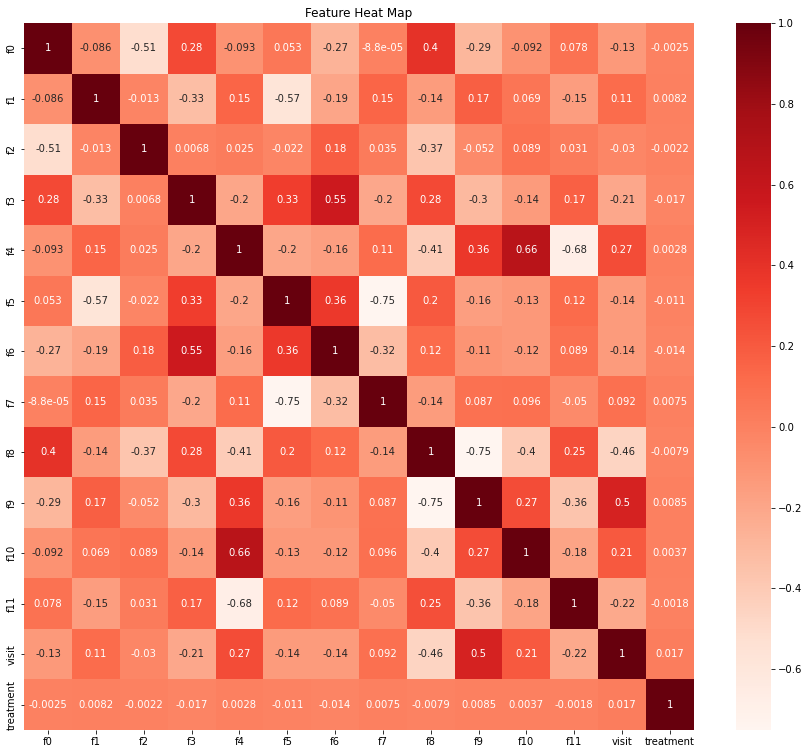

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,13))
cor = data.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Feature Heat Map")
plt.show()

In [ ]:
# variance inflation factor(VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
#data = add_constant(data)
multicor=pd.DataFrame([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], columns=["VIF"])
multicor["Tolerance"]=1/multicor["VIF"]
multicor["Feature"]=data.columns
multicor=multicor.sort_values(["VIF"], ascending=False )
multicor["VIF"]

5     2642.777049
11    2507.481478
3      198.723595
8      126.867532
6       81.605252
13       6.666791
0        6.091387
9        4.277809
2        3.652679
4        2.621449
7        2.478556
10       2.142457
1        1.703003
12       1.455968
Name: VIF, dtype: float64

## 1 Average Treatment Effect (ATE) Estimation

In [ ]:
multi_data["conversion"]

0           0
1           0
2           0
3           0
4           0
           ..
13979587    0
13979588    0
13979589    0
13979590    0
13979591    0
Name: conversion, Length: 13979592, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
sampler = RandomUnderSampler(random_state=(2022),sampling_strategy={0:40000,1:40000})
X_sampled,y_sampled=sampler.fit_resample(data, multi_data["conversion"])

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from econml.dml import LinearDML, CausalForestDML

feats_ate={}
for i in X_sampled.columns:
        T=X_sampled[i]
        X=X_sampled.drop(columns=[i,]) 
        
        # Train EconML model
        if i in numeric_disc:
            est = CausalForestDML(model_y=GradientBoostingRegressor(), 
                                  model_t=GradientBoostingClassifier(),
                                  cv=10,
                                  criterion='mse', 
                                  n_estimators=400,
                                  min_var_fraction_leaf=0.1,
                                  min_var_leaf_on_val=True,
                                  verbose=0,
                                  n_jobs=-1, 
                                  random_state=2022,
                                  discrete_treatment=True)
        else:
            est = CausalForestDML(model_y=GradientBoostingRegressor(), 
                                  model_t=GradientBoostingRegressor(),
                                  cv=10,
                                  criterion='mse', 
                                  n_estimators=400,
                                  min_var_fraction_leaf=0.1,
                                  min_var_leaf_on_val=True,
                                  verbose=0,
                                  n_jobs=-1, 
                                  random_state=2022,
                                  discrete_treatment=False)
        est.fit(Y=y_sampled, T=T,X=X,cache_values=True) # T is matrix with size (n_samples, n_treatments)
        # Get average treatment effect to Y
        ate=est.ate(X)
        print(ate)
        print("treatments",i,"has ate of",ate,"\n")

        feats_ate[i]=ate

-0.013886796627241927
treatments f0 has ate of -0.013886796627241927 

0.050715383715345175
treatments f1 has ate of 0.050715383715345175 

0.001328853128405821
treatments f2 has ate of 0.001328853128405821 

-0.009331114629769072
treatments f3 has ate of -0.009331114629769072 

0.1933108932875426
treatments f4 has ate of 0.1933108932875426 

0.0008912893595676433
treatments f5 has ate of 0.0008912893595676433 

-0.0002958249515911775
treatments f6 has ate of -0.0002958249515911775 

-0.009201954095841196
treatments f7 has ate of -0.009201954095841196 

0.10345749255334895
treatments f8 has ate of 0.10345749255334895 

0.0741312293943781
treatments f9 has ate of 0.0741312293943781 

-0.01664079180275199
treatments f10 has ate of -0.01664079180275199 

0.13315628992437864
treatments f11 has ate of 0.13315628992437864 

0.9310119697738223
treatments visit has ate of 0.9310119697738223 

0.007447354046319239
treatments treatment has ate of 0.007447354046319239 



In [ ]:
feats_ate

{'f0': -0.013886796627241927,
 'f1': 0.050715383715345175,
 'f2': 0.001328853128405821,
 'f3': -0.009331114629769072,
 'f4': 0.1933108932875426,
 'f5': 0.0008912893595676433,
 'f6': -0.0002958249515911775,
 'f7': -0.009201954095841196,
 'f8': 0.10345749255334895,
 'f9': 0.0741312293943781,
 'f10': -0.01664079180275199,
 'f11': 0.13315628992437864,
 'visit': 0.9310119697738223,
 'treatment': 0.007447354046319239}

In [ ]:
ate_df=pd.DataFrame.from_dict(feats_ate,orient='index',columns=["ATE"]).reset_index().rename({"index":"Feature"},axis=1)
ate_df=ate_df[(ate_df["Feature"]!="score") & (ate_df["Feature"]!="flag")].sort_values(["ATE"], ascending=False).reset_index(drop=True)
ate_df.to_excel("feats_ate_x13.xlsx")